Env
- matplotlib
- pandas
- tqdm
- xarrray
- cmocean
- erddapy
- argopy

In [1]:
import matplotlib.dates as mdates
from matplotlib import style
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ast
import datetime
from tqdm import tqdm
import xarray as xr
from cmocean import cm as cmo
import sys
from erddapy import ERDDAP


## Structure:

0. ERDDAP-How to access data
1. Åland sea data
2. Baltic Inflow
3. Hans Storm
4. Spring blooms and annual cycle
5. Issue with CTD data

### 0. ERDDAP-How to access data 
We need some functions in untils to download data from ERDDAP
You need to have erddap_demo on your computer 


https://github.com/voto-ocean-knowledge/erddap_demo use git clone to get this on your computer and the adjust the path in order to import all the functions

Observations portal VOTO https://observations.voiceoftheocean.org/

In [2]:
sys.path.append('/Users/eddifying/Library/Mobile Documents/com~apple~CloudDocs/Work/teaching/SeaOcn-UHH/2024-SeaOcn/05-github/erddap_demo')
#sys.path.append('C:\\Users\\u241346\\uni_hamburg\\erddap_demo')
import erddaputils as utils

In [3]:
e = utils.init_erddap()

# Fetch dataset list of all dataset existing
e.response = "csv"
e.dataset_id = "allDatasets"
df_datasets = e.to_pandas(parse_dates=['minTime (UTC)', 'maxTime (UTC)'])

print(f"found {len(df_datasets)} datasets")

found 499 datasets


In [4]:
# drop the allDatasets row and make the datasetID the index for easier reading
df_datasets.set_index("datasetID", inplace=True)
df_datasets.drop("allDatasets", inplace=True)

# Get only nrt data (near real time) and not delayed as otherwise it would be very long for an intial data exploration
df_datasets = df_datasets[df_datasets.index.str[:3] == "nrt"]
ds_meta = {}
for dataset_id in tqdm(df_datasets.index):
    ds_meta[dataset_id] = utils.get_meta(dataset_id)

100%|███████████████████████████████████████████████████████████████████████████████████████| 197/197 [01:56<00:00,  1.69it/s]


Stats to see where data is available and since when https://observations.voiceoftheocean.org/stats

We just downlaoded info on all data so that now we can just find the specific datasets we want based on specific criteria

## 1. Åland sea data

In [19]:
name=[]
for dataset_id, meta in ds_meta.items():
    if meta['deployment_start']>'2023-02-01':
        if 'Åland' in meta['basin']:
            name.append(dataset_id)
print(f'Found {len(name)} datasets in Åland: {name}')

Found 5 datasets in Åland: ['nrt_SEA076_M21', 'nrt_SEA076_M24', 'nrt_SEA077_M29', 'nrt_SEA056_M68', 'nrt_SEA078_M24']


In [20]:
name = [name[4]]

In [21]:
ds_nrt = utils.download_glider_dataset(name, nrt_only=True) 

  0%|                                                                                                   | 0/1 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


### We use only nrt data and not delayed mode as it would be way slower otherwise
NRT data is generally contains only one file every 3-4h (lastest dive of 2 to 12 multidives) and data is subsampled (30s instead of data every second)
In deep areas as the Åland sea this means that in the NRT files we have generally every other dive with subsampled data. In shallower locations as the Bornholm basin, it means that we get one data file every 6 to 8 dives and subsampled.
In areas with a more complex bathymetry as the Kattegat/Skagerrak area where the glider dives as deep as 200m in the north and as shallow as 40m in the south, we then receive files every 2 to 12 dives for the NRT dataset. 

In [23]:
# Example of datasets so one can see where the metadata is and how it is structured and what the variables are and what the units are
miss1 = name[0]

ds_nrt[miss1]


<xarray.Dataset>
Dimensions:                        (time: 23775)
Coordinates:
    latitude                       (time) float64 ...
    longitude                      (time) float64 ...
  * time                           (time) datetime64[ns] 2024-03-20T11:40:24....
    depth                          (time) float64 ...
Data variables: (12/57)
    ad2cp_beam1_cell_number1       (time) float32 ...
    ad2cp_beam2_cell_number1       (time) float32 ...
    ad2cp_beam3_cell_number1       (time) float32 ...
    ad2cp_beam4_cell_number1       (time) float32 ...
    ad2cp_heading                  (time) float32 ...
    ad2cp_pitch                    (time) float32 ...
    ...                             ...
    security_level                 (time) float32 ...
    temperature                    (time) float32 ...
    temperature_oxygen             (time) float32 ...
    temperature_qc                 (time) float32 ...
    vertical_distance_to_seafloor  (time) float32 ...
    voltage                        (time) float32 ...
Attributes: (12/76)
    acknowledgement:               This study used data collected and made fr...
    AD2CP:                         {'calibration_date': '2022-07-18', 'factor...
    basin:                         Åland Sea
    cdm_data_type:                 TimeSeries
    cdm_timeseries_variables:      profile_index
    contributor_name:              Callum Rollo, Louise Biddle, Olle Petersso...
    ...                            ...
    title:                         Vresros78-20240320T1140
    total_dives:                   118.0
    transmission_system:           IRIDIUM
    variables:                     time\nlatitude\nlongitude\nnav_state\nhead...
    Westernmost_Easting:           19.36478333333333
    wmo_id:                        8901000

/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


[Text(0, 0.5, 'Depth (m)'),
 Text(0, 0.5, 'Depth (m)'),
 Text(0, 0.5, 'Depth (m)'),
 Text(0, 0.5, 'Depth (m)'),
 Text(0, 0.5, 'Depth (m)')]

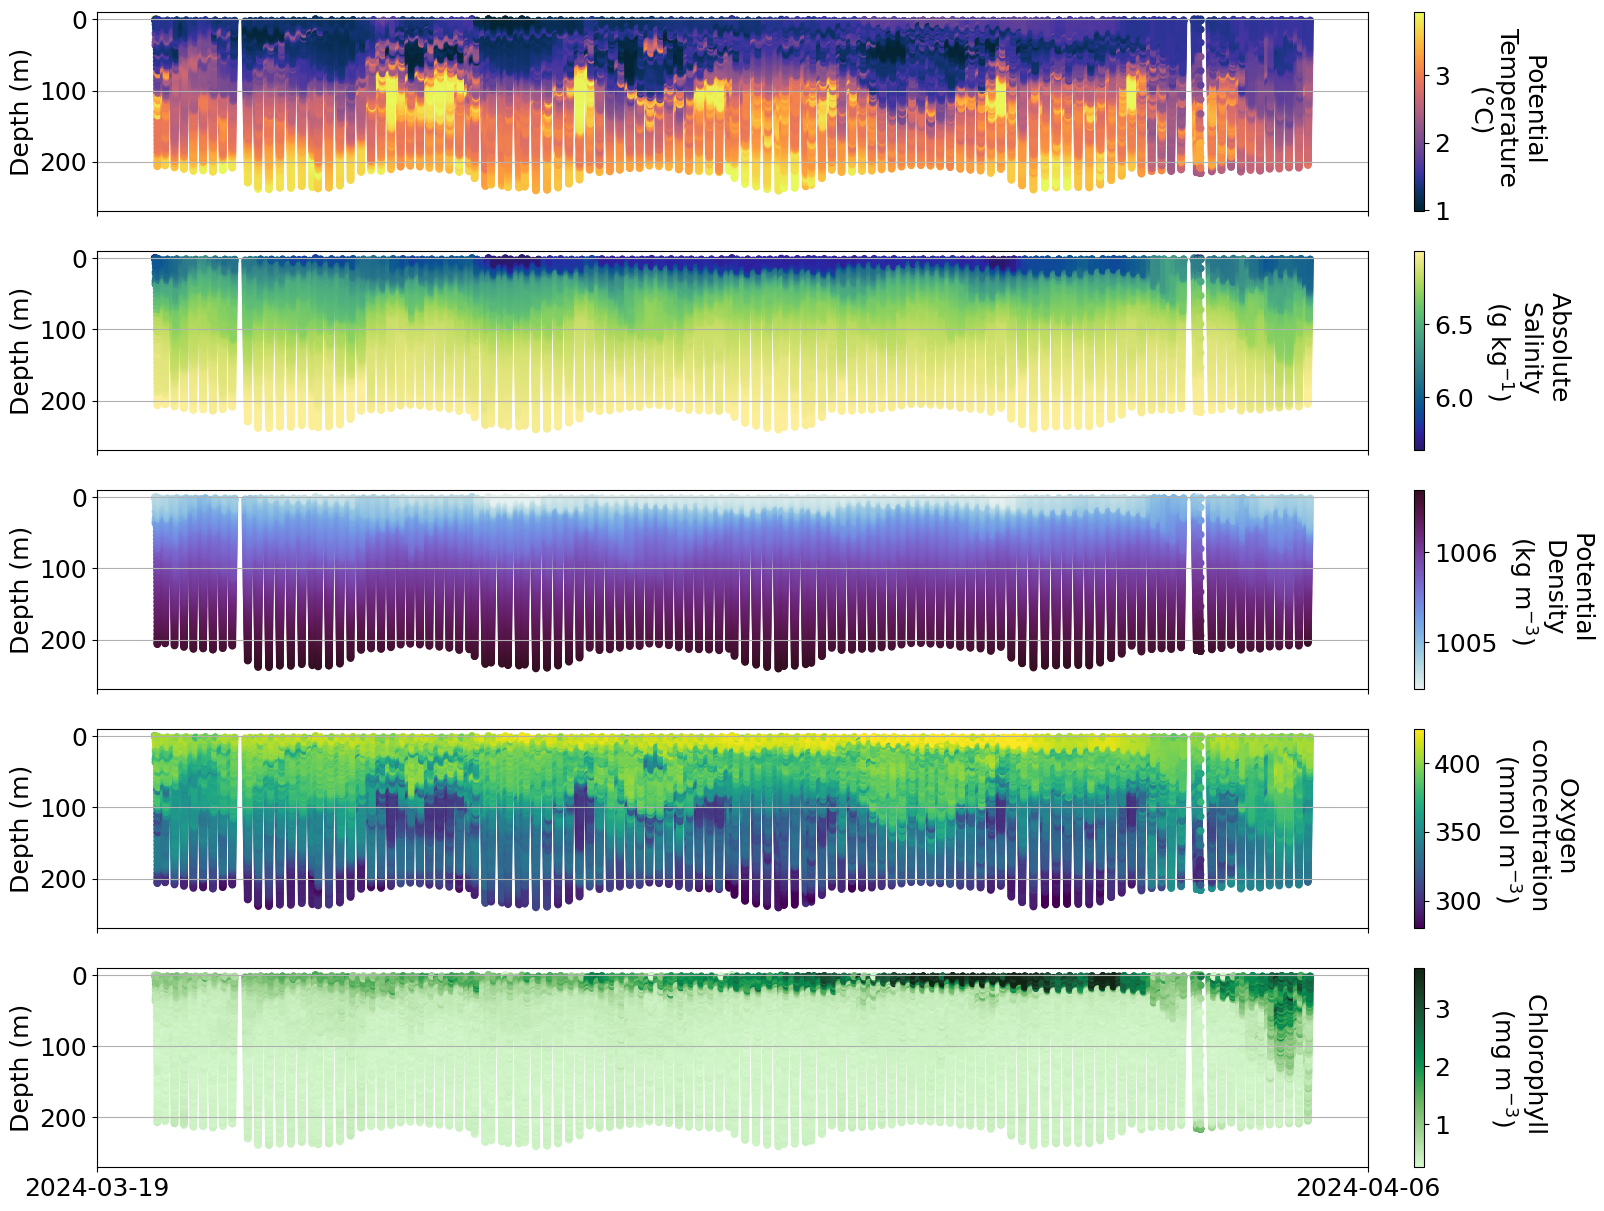

In [24]:
full_data = []
for i in range(len(name)):
    full_data.append(ds_nrt[name[i]])
full_data = xr.concat(full_data, dim= 'time')

fig, ax = plt.subplots(5,1,figsize=(20, 15), sharex=True)
matplotlib.rcParams.update({'font.size': 18})
time=mdates.date2num(full_data.time)
t=ax[0].scatter( time,full_data.depth, c=full_data.temperature,s=20, cmap=cmo.thermal, vmin=np.nanpercentile(full_data.temperature, 0.5), vmax=np.nanpercentile(full_data.temperature, 99.5))
s=ax[1].scatter( time,full_data.depth, c=full_data.salinity,s=20,cmap=cmo.haline, vmin=np.nanpercentile(full_data.salinity, 0.5), vmax=np.nanpercentile(full_data.salinity, 99.5))
d=ax[2].scatter( time,full_data.depth, c=full_data.density, s=20, cmap=cmo.dense, vmin=np.nanpercentile(full_data.density, 0.5), vmax=np.nanpercentile(full_data.density, 99.5))
o=ax[3].scatter( time,full_data.depth, c=full_data.oxygen_concentration, s=20,vmin=np.nanpercentile(full_data.oxygen_concentration, 0.5), vmax=np.nanpercentile(full_data.oxygen_concentration, 99.5))
c=ax[4].scatter( time,full_data.depth, c=full_data.chlorophyll, s=20, cmap=cmo.algae, vmin=np.nanpercentile(full_data.chlorophyll, 0.5), vmax=np.nanpercentile(full_data.chlorophyll, 99.5))
    
[a.set_ylim(270,-10) for a in ax]
[a.grid() for a in ax]
ax[1].xaxis.reset_ticks()
ax[1].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday = 1, interval=3))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))


cbarT=plt.colorbar(t, ax=ax[0], pad = 0.03)
cbarT.set_label('Potential \nTemperature \n(°C)',labelpad=70, y=0.5, rotation=270,fontsize=18)
cbarS=plt.colorbar(s, ax=ax[1], pad = 0.03)
cbarS.set_label('Absolute \nSalinity \n(g kg$^{-1}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)
cbarD=plt.colorbar(d, ax=ax[2], pad = 0.03)
cbarD.set_label('Potential \nDensity \n(kg m$^{-3}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)
cbarO=plt.colorbar(o, ax=ax[3], pad = 0.03)
cbarO.set_label('Oxygen \nconcentration \n(mmol m$^{-3}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)
cbarC=plt.colorbar(c, ax=ax[4], pad = 0.03)
cbarC.set_label('Chlorophyll \n(mg m$^{-3}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)

[a.tick_params(axis='both', which='major', labelsize=18) for a in ax]
[a.set_ylabel('Depth (m)',fontsize=18) for a in ax]

## 2. Baltic inflow 

What are Baltic Inflows?

The deep water in the Baltic Proper is renewed during specific conditions when salt water from the Kattegat flows through the Belt and the Sound and fills in turn the deep areas of the Arkona Basin, the Bornholm Basin, the Eastern Gotland Basin and the western Gotland Basin. They manifest as bottom gravity currents.

The Baltic Sea is a very enclosed sea characterized by brakish waters, and salt water only enters through the narrow Danish straits. Waterer masses change in the upper layers and interlayer, but not near the bottom. The deep waters of the Baltic sea are anoxic. When large amounts of salty water from the North Sea enters the Baltic, this salty and dense oxygen-rich water can replace the anoxic deep water. Such events are called Mjor Baltic Inflows (MBI) which are a necessary phenomena as they allow oxygen to be replenished in the deepest parts of the Baltic.

Detect baltic inflows in time for observation can be a challenge for onservations of Baltic inflows. The short duration of the inflows of 2–3 weeks poses a challenge to ﬁeld measurements, thus the BIs are prone to undersampling and difﬁcult to predict. Since regular monitoring cruises in the Baltic Sea are typically scheduled less frequently than once a month, the likelihood to miss or only partially resolve it is high.
mpact

In December a Baltic inflow was detected. This recent inflow brought 80 km3 new salty water into the Baltic Sea, making this event a medium size inflow. 
The last one comparable is at least 5 years ago. The inflow corresponds to 1.6 Gt (1.6 billion t) of salt. First event of that scale since VOTO observatories started. 

Estimated that by the beginning of February, the deep water in Bornholm Basin will be exchanged by the new 

https://news.err.ee/1609206383/rare-saltwater-inflow-in-baltic-sea-could-have-widespread-environmental-impactter.



In [25]:
# We want to find data from the Bornholm Basin (the first basin after the Danish straits) from early December 2023 until now

name=[]
for dataset_id, meta in ds_meta.items():
    if meta['deployment_end']>'2023-12-01':
        if 'Bornholm' in meta['basin']:
            name.append(dataset_id)
print(f'Found {len(name)} datasets in Bornholm: {name}')

Found 7 datasets in Bornholm: ['nrt_SEA068_M30', 'nrt_SEA063_M69', 'nrt_SEA063_M71', 'nrt_SEA063_M72', 'nrt_SEA067_M51', 'nrt_SEA067_M53', 'nrt_SEA067_M55']


In [31]:
name1 = [name[5]]
ds_nrt = utils.download_glider_dataset(name1, nrt_only=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.95it/s]

/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


[Text(0, 0.5, 'Depth (m)'),
 Text(0, 0.5, 'Depth (m)'),
 Text(0, 0.5, 'Depth (m)'),
 Text(0, 0.5, 'Depth (m)')]

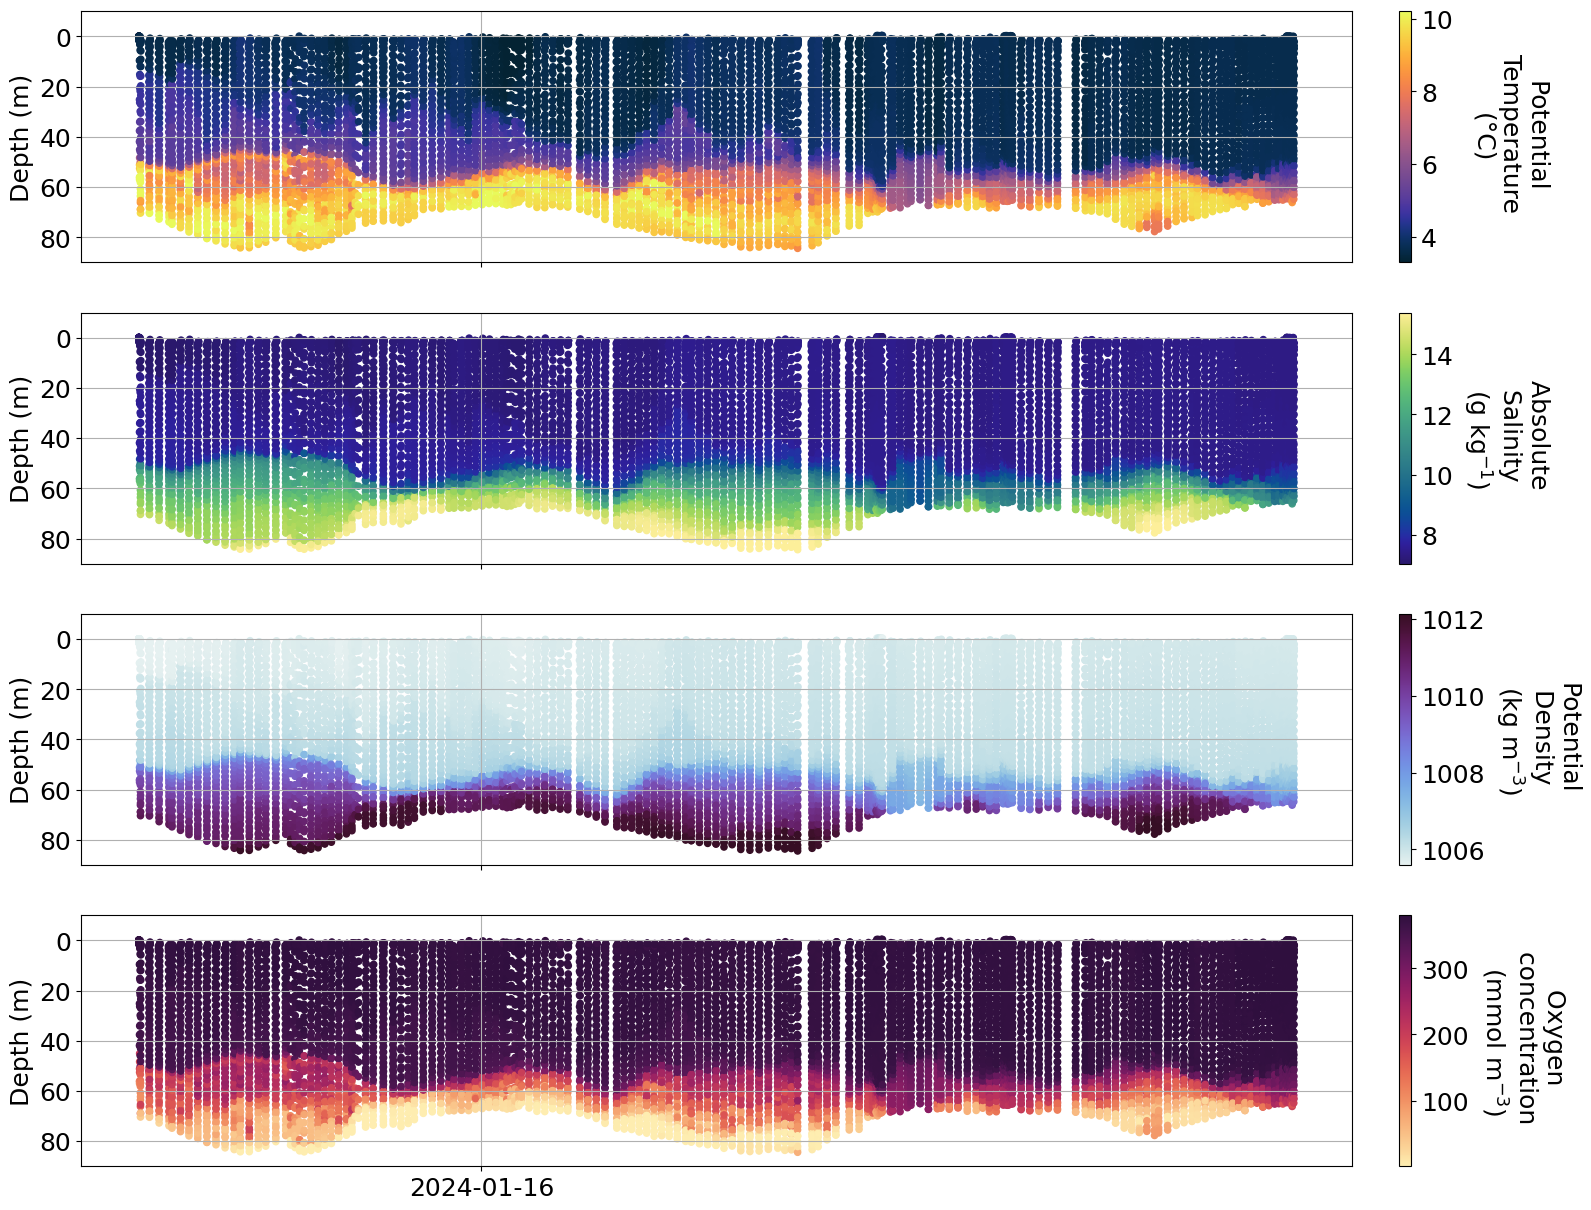

In [33]:
full_data = []
for i in range(len(name1)):
    full_data.append(ds_nrt[name1[i]])
full_data = xr.concat(full_data, dim= 'time')

fig, ax = plt.subplots(4,1,figsize=(20, 15), sharex=True)
matplotlib.rcParams.update({'font.size': 18})
time=mdates.date2num(full_data.time)
t=ax[0].scatter( time,full_data.depth, c=full_data.temperature,s=20, cmap=cmo.thermal, vmin=np.nanpercentile(full_data.temperature, 0.5), vmax=np.nanpercentile(full_data.temperature, 99.5))
s=ax[1].scatter( time,full_data.depth, c=full_data.salinity,s=20,cmap=cmo.haline, vmin=np.nanpercentile(full_data.salinity, 0.5), vmax=np.nanpercentile(full_data.salinity, 99.5))
d=ax[2].scatter( time,full_data.depth, c=full_data.density, s=20, cmap=cmo.dense, vmin=np.nanpercentile(full_data.density, 0.5), vmax=np.nanpercentile(full_data.density, 99.5))
o=ax[3].scatter( time,full_data.depth, c=full_data.oxygen_concentration,cmap=cmo.matter, s=20,vmin=np.nanpercentile(full_data.oxygen_concentration, 0.5), vmax=np.nanpercentile(full_data.oxygen_concentration, 99.5))

[a.set_ylim(90,-10) for a in ax]
[a.grid() for a in ax]
ax[1].xaxis.reset_ticks()
ax[1].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday = 1, interval=3))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))


cbarT=plt.colorbar(t, ax=ax[0], pad = 0.03)
cbarT.set_label('Potential \nTemperature \n(°C)',labelpad=70, y=0.5, rotation=270,fontsize=18)
cbarS=plt.colorbar(s, ax=ax[1], pad = 0.03)
cbarS.set_label('Absolute \nSalinity \n(g kg$^{-1}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)
cbarD=plt.colorbar(d, ax=ax[2], pad = 0.03)
cbarD.set_label('Potential \nDensity \n(kg m$^{-3}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)
cbarO=plt.colorbar(o, ax=ax[3], pad = 0.03)
cbarO.set_label('Oxygen \nconcentration \n(mmol m$^{-3}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)

[a.tick_params(axis='both', which='major', labelsize=18) for a in ax]
[a.set_ylabel('Depth (m)',fontsize=18) for a in ax]

#### Info
There are issues with some of the oxygen data and more info can be found here https://observations.voiceoftheocean.org/static/img/reports/Quality_Issue_1_AROD.pdf

## 3. Hans storm
https://www.krisinformation.se/en/hazards-and-risks/disasters-and-incidents/2023/storm-hans

https://www.theguardian.com/world/2023/aug/08/storm-hans-causes-havoc-in-norway-with-heaviest-rain-in-25-years-forecast

https://www.su.se/department-of-geological-sciences/news/hans-is-the-perfect-storm-globalwarming-contributed-1.664948

During the first week on August 2023 a strong storm hit Sweden and Norway causing big floodings and high water level in multiple areas.

Is it possible to see the effect of the storm on any of the glider data?

In [34]:
## We look for all the glider data avaialble from early July to end of August
name=[]
for dataset_id, meta in ds_meta.items():
    if meta['deployment_start']>'2023-07-01':
        if meta['deployment_start']<'2023-09-01':
            name.append(dataset_id)
print(f'Found {len(name)} datasets between July 1st 2023 and September 1st 2023: {name}')

Found 9 datasets between July 1st 2023 and September 1st 2023: ['nrt_SEA069_M15', 'nrt_SEA063_M62', 'nrt_SEA063_M63', 'nrt_SEA044_M83', 'nrt_SEA044_M84', 'nrt_SEA044_M85', 'nrt_SEA067_M46', 'nrt_SEA077_M24', 'nrt_SEA078_M14']


In [35]:
ds_nrt = utils.download_glider_dataset(name, nrt_only=True)

  0%|                                                                                                   | 0/9 [00:00<?, ?it/s]

 11%|██████████                                                                                 | 1/9 [00:00<00:03,  2.29it/s]

/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
 22%|████████████████████▏                                                                      | 2/9 [00:00<00:02,  2.37it/s]

/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
 33%|██████████████████████████████▎                                                            | 3/9 [00:01<00:02,  2.31it/s]

 44%|████████████████████████████████████████▍                                                  | 4/9 [00:01<00:02,  2.26it/s]

 56%|██████████████████████████████████████████████████▌                                        | 5/9 [00:02<00:01,  2.30it/s]

 67%|████████████████████████████████████████████████████████████▋                              | 6/9 [00:02<00:01,  2.33it/s]

/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
 78%|██████████████████████████████████████████████████████████████████████▊                    | 7/9 [00:03<00:00,  2.34it/s]

/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
 89%|████████████████████████████████████████████████████████████████████████████████▉          | 8/9 [00:03<00:00,  1.68it/s]

/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
100%|███████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.78it/s]


In [36]:
## We want to see where the data  is from and get a bit more info summarized
table=pd.DataFrame(columns = ['Glider','Location','Mission','Start_Date'])
missions=name
dic=ds_nrt
table.Mission= range(0,len(missions))
    
for i in range(len(missions)): 
    d=dic[missions[i]]
    table.loc[i, 'Glider']=f'SEA0{int(d.attrs["glider_serial"])}'
    table.loc[i,'Mission']=int(d.attrs["deployment_id"])
    table.loc[i, 'Start_Date']=d.attrs["deployment_start"][:10]
    table.loc[i,'Location']=d.attrs["basin"]


table.sort_values(by=["Start_Date"], ascending=True)

Glider                                       Location  Mission  Start_Date
1  SEA063                                 Bornholm Basin       62  2023-07-08
3  SEA044                            Skagerrak, Kattegat       83  2023-07-10
0  SEA069                                 Bornholm Basin       15  2023-07-26
6  SEA067                                 Bornholm Basin       46  2023-07-26
7  SEA077  Eastern Gotland Basin, Northern Baltic Proper       24  2023-07-28
8  SEA078                          Western Gotland Basin       14  2023-07-28
4  SEA044                            Skagerrak, Kattegat       84  2023-08-04
2  SEA063                                 Bornholm Basin       63  2023-08-11
5  SEA044                            Skagerrak, Kattegat       85  2023-08-23

In [37]:
print(f'We have data from {len(table.Location.unique())} different sites during this period: {table.Location.unique()}')

We have data from 4 different sites during this period: ['Bornholm Basin' 'Skagerrak, Kattegat'
 'Eastern Gotland Basin, Northern Baltic Proper' 'Western Gotland Basin']


In [38]:
# We can try to plot data and see if anything is visible in any of the 4 areas

In [39]:
def plot_sel_data(basin='Bornholm', date_start='2023-07-01', date_end='2023-09-01', rectangle=True,  delayed = False):
    
    name=[]
    for dataset_id, meta in ds_meta.items():
        if meta['deployment_start']>date_start:
            if meta['deployment_start']<date_end:
                if basin in meta['basin']:
                    if 'SAMBA' in meta['project']:
                        if delayed == True:
                            name.append(f'delayed{dataset_id[3:]}')
                        else:
                            name.append(dataset_id)
    
        
    ds_nrt = utils.download_glider_dataset(name, nrt_only=False)
    
    full_data = []
    for i in range(len(name)):
        full_data.append(ds_nrt[name[i]])
    full_data = xr.concat(full_data, dim= 'time')
    
    fig, ax = plt.subplots(5,1,figsize=(20, 15), sharex=True)
    
    time=mdates.date2num(full_data.time)
    t=ax[0].scatter( time,full_data.depth, c=full_data.temperature,s=20, cmap=cmo.thermal, vmin=np.nanpercentile(full_data.temperature, 0.5), vmax=np.nanpercentile(full_data.temperature, 99.5))
    s=ax[1].scatter( time,full_data.depth, c=full_data.salinity,s=20,cmap=cmo.haline, vmin=np.nanpercentile(full_data.salinity, 0.5), vmax=np.nanpercentile(full_data.salinity, 99.5))
    d=ax[2].scatter( time,full_data.depth, c=full_data.density, s=20, cmap=cmo.dense, vmin=np.nanpercentile(full_data.density, 0.5), vmax=np.nanpercentile(full_data.density, 99.5))
    o=ax[3].scatter( time,full_data.depth, c=full_data.oxygen_concentration, s=20,vmin=np.nanpercentile(full_data.oxygen_concentration, 0.5), vmax=np.nanpercentile(full_data.oxygen_concentration, 99.5))
    c=ax[4].scatter( time,full_data.depth, c=full_data.chlorophyll, s=20, cmap=cmo.algae, vmin=np.nanpercentile(full_data.chlorophyll, 0.5), vmax=np.nanpercentile(full_data.chlorophyll, 99.5))
    
    # Highlight storm period
    if rectangle:
        for a in ax: 
            rect = patches.Rectangle((int(mdates.date2num(['2023-08-07'])[0]), int(full_data.depth.max())), 5, 3, linewidth=5, edgecolor='r', facecolor='red', fill='red')
            a.add_patch(rect) 
    
    [a.set_ylim(int(full_data.depth.max())+5,-10) for a in ax]
    [a.grid() for a in ax]

    ax[4].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[4].locator_params(axis='x', nbins=8) 
    
    cbarT=plt.colorbar(t, ax=ax[0], pad = 0.03)
    cbarT.set_label('Potential \nTemperature \n(°C)',labelpad=70, y=0.5, rotation=270,fontsize=18)
    cbarS=plt.colorbar(s, ax=ax[1], pad = 0.03)
    cbarS.set_label('Absolute \nSalinity \n(g kg$^{-1}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)
    cbarD=plt.colorbar(d, ax=ax[2], pad = 0.03)
    cbarD.set_label('Potential \nDensity \n(kg m$^{-3}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)
    cbarO=plt.colorbar(o, ax=ax[3], pad = 0.03)
    cbarO.set_label('Oxygen \nconcentration \n(mmol m$^{-3}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)
    cbarC=plt.colorbar(c, ax=ax[4], pad = 0.03)
    cbarC.set_label('Chlorophyll \n(mg m$^{-3}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)
    
    [a.tick_params(axis='both', which='major', labelsize=18) for a in ax]
    [a.set_ylabel('Depth (m)',fontsize=18) for a in ax]
    


In [40]:
plot_sel_data(basin='Bornholm',date_start='2023-07-01', date_end='2023-09-01',)

  0%|                                                                                                   | 0/4 [00:00<?, ?it/s]/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
100%|███████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 40.55it/s]


ValueError: 'backscatter_raw' is not present in all datasets.

  0%|                                                                                                   | 0/1 [00:00<?, ?it/s]/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.33it/s]
/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


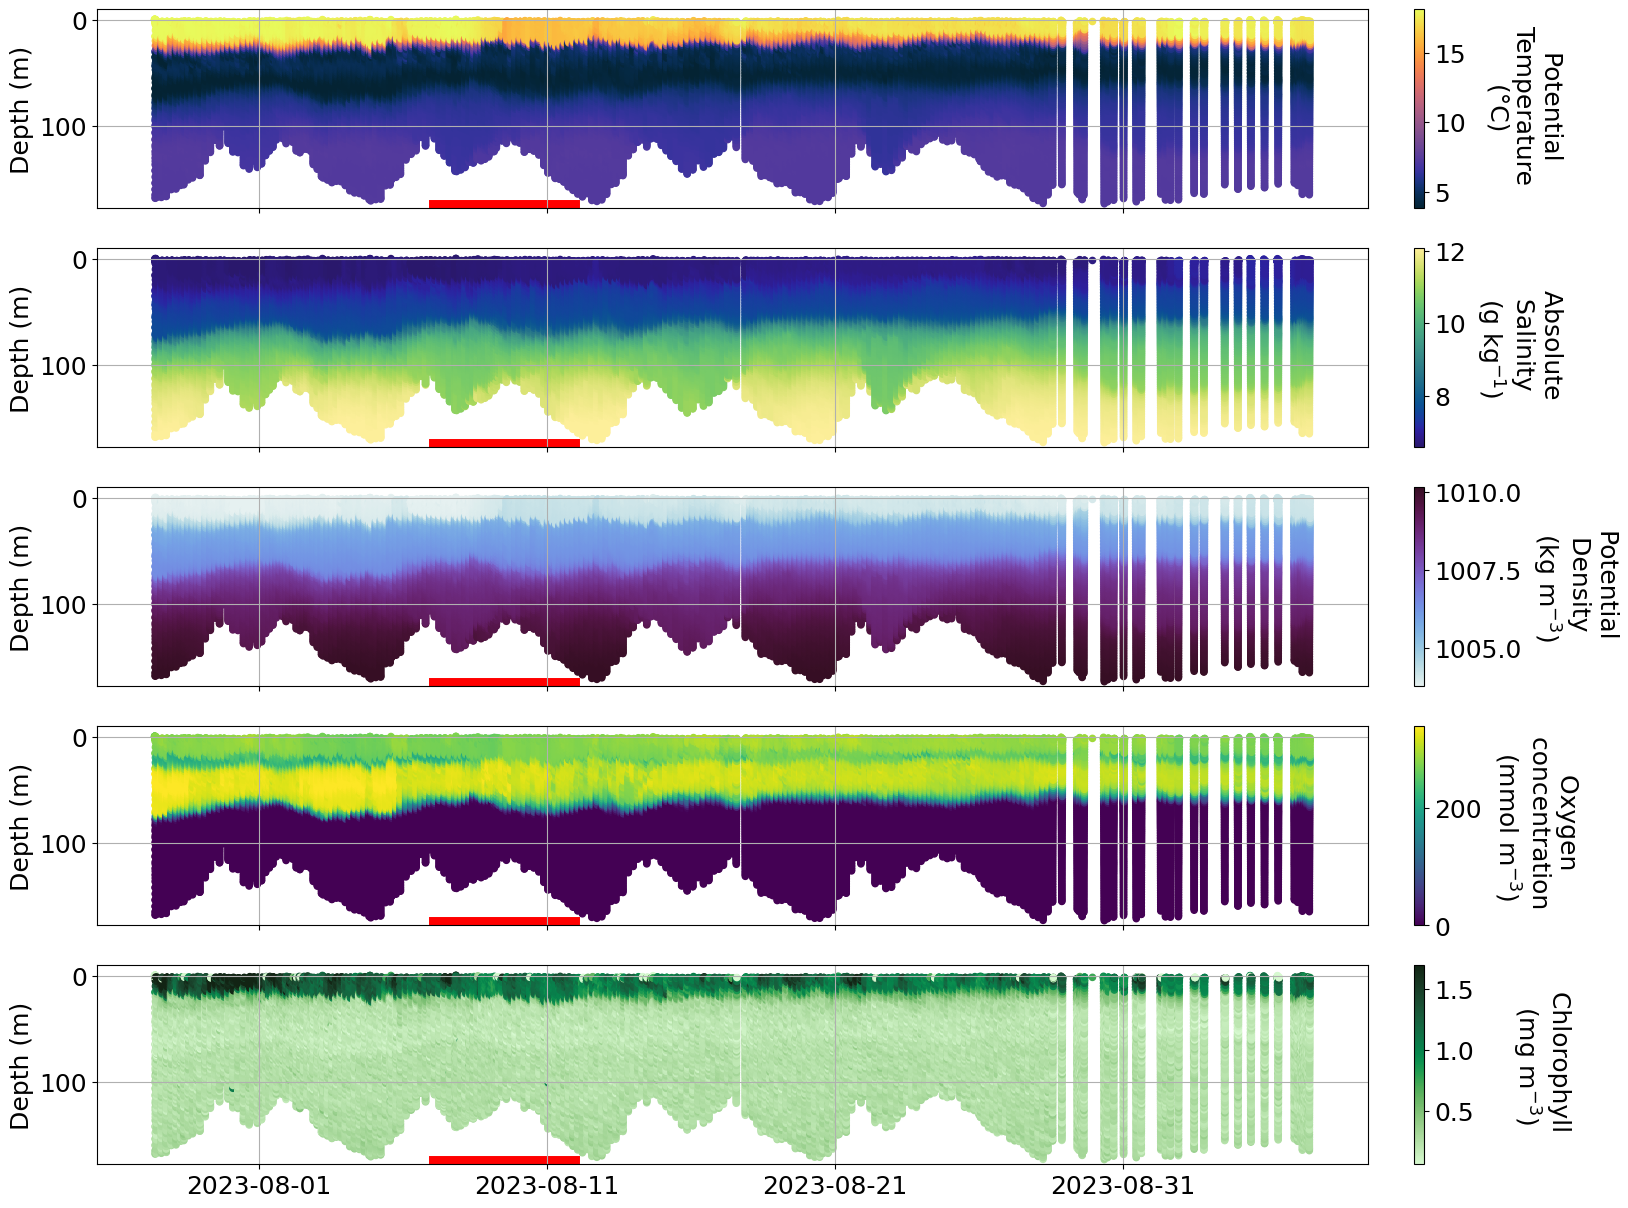

In [41]:
plot_sel_data(basin='Eastern Gotland',date_start='2023-07-01', date_end='2023-09-01')

  0%|                                                                                                   | 0/1 [00:00<?, ?it/s]/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.16it/s]
/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


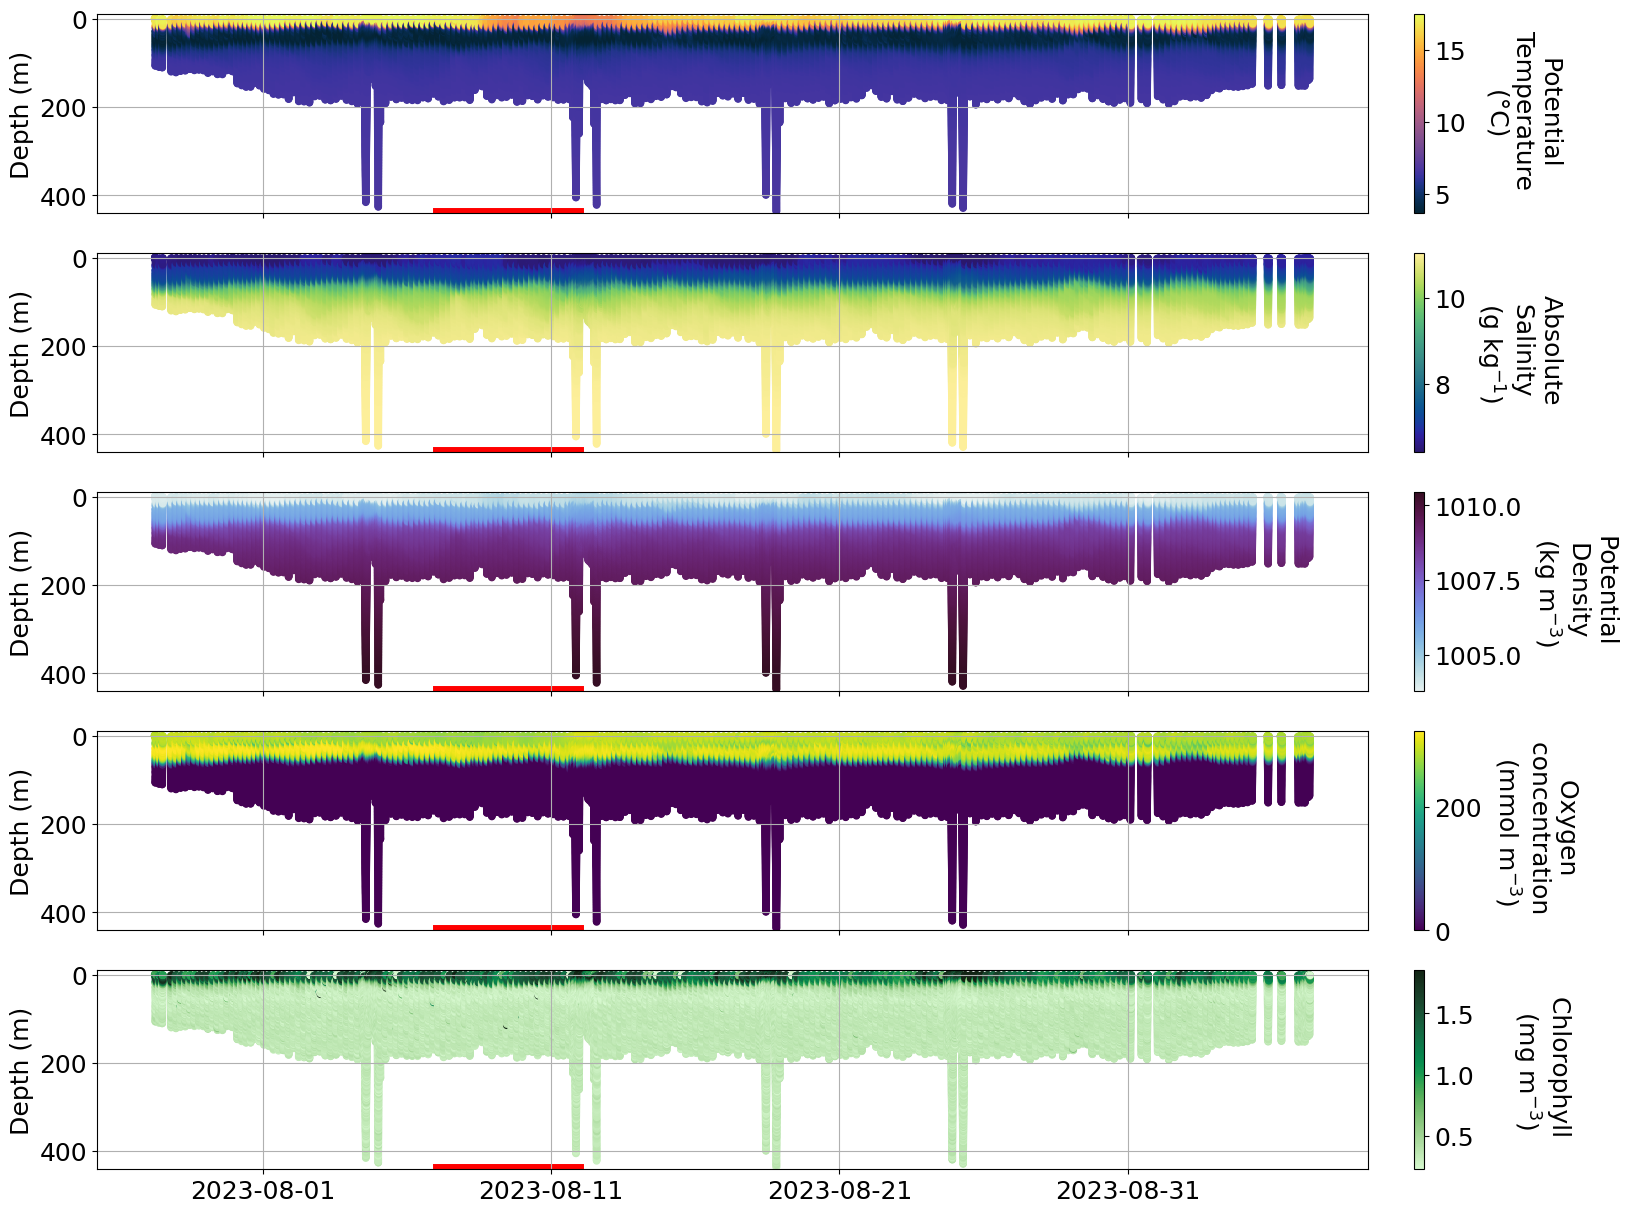

In [42]:
plot_sel_data(basin='Western Gotland',date_start='2023-07-01', date_end='2023-09-01')

100%|███████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 58.90it/s]


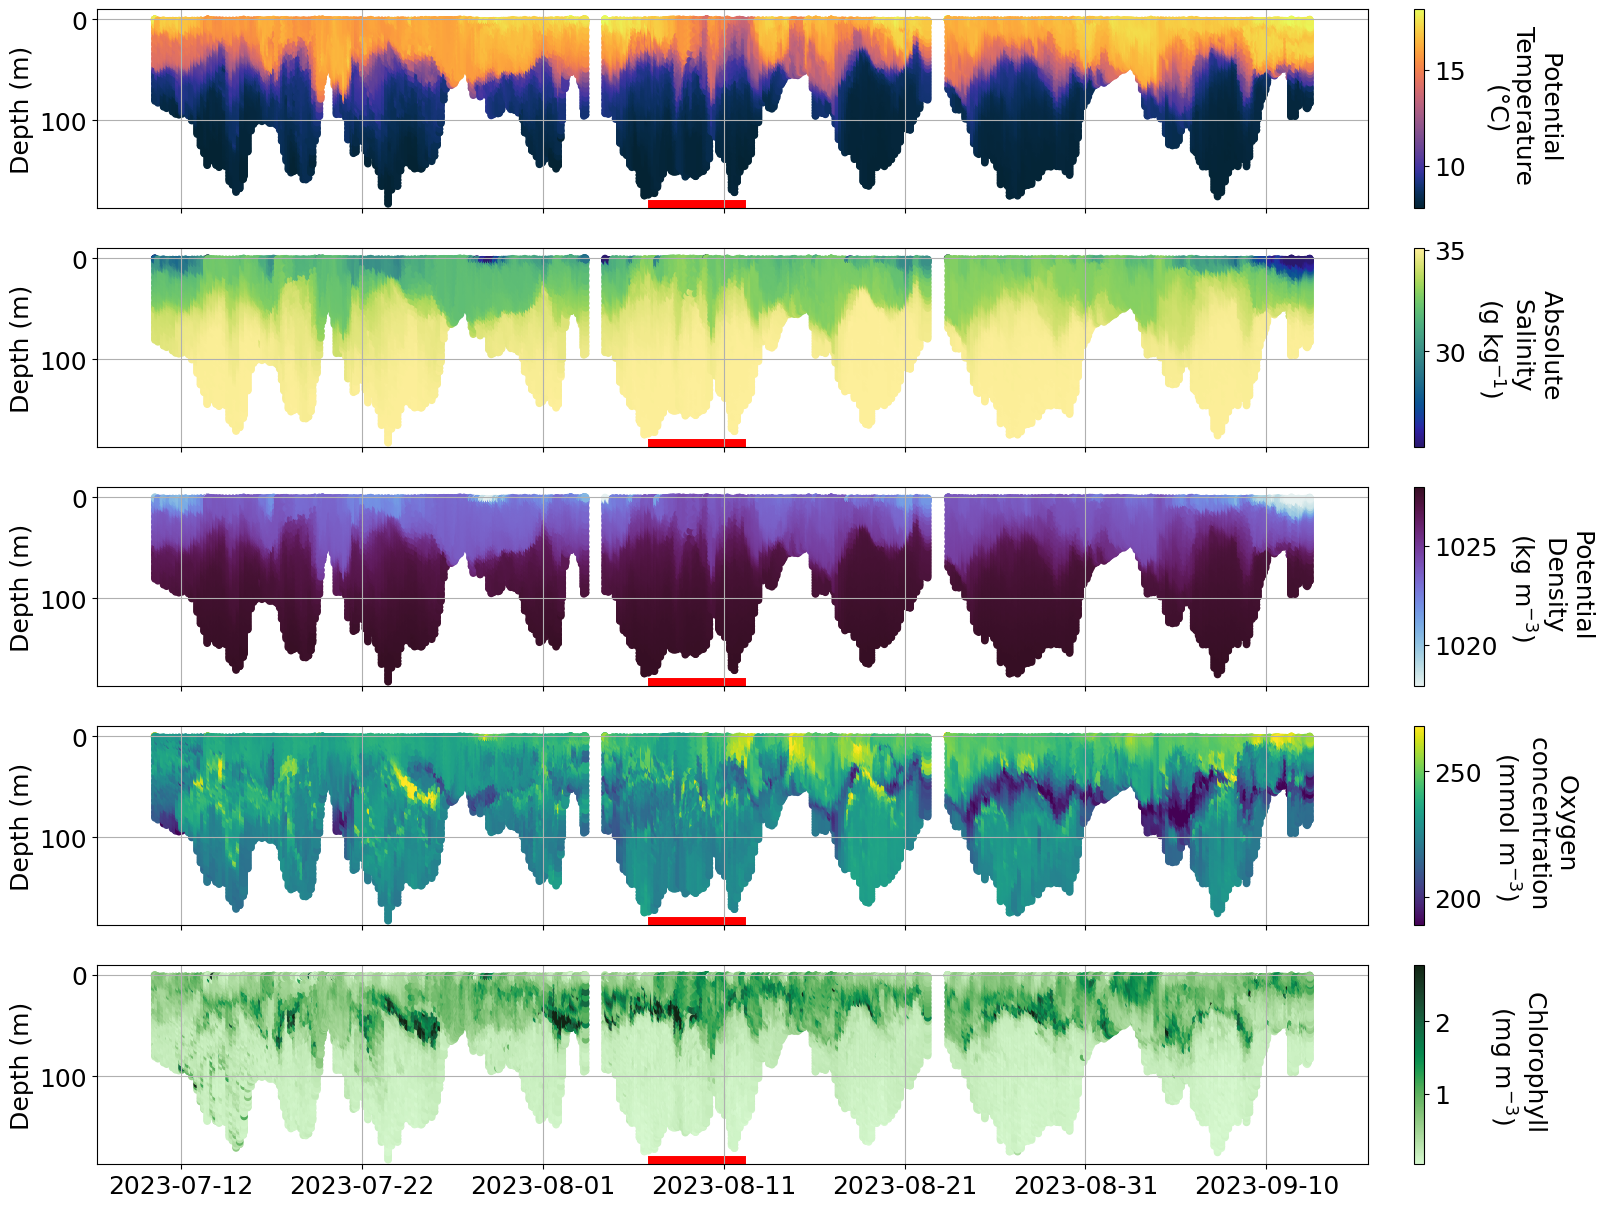

In [43]:
plot_sel_data(basin='Kattegat', date_start='2023-07-01', date_end='2023-09-01')

  0%|                                                                                                   | 0/1 [00:00<?, ?it/s]

Creating directory to cache datasets at /Users/eddifying/Library/Mobile Documents/com~apple~CloudDocs/Work/teaching/SeaOcn-UHH/coursebook_seaocn/seaocn-cb/exercise/voto_erddap_data_cache


/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


Writing voto_erddap_data_cache/delayed_SEA078_M14.nc


/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:613: RuntimeWarning: invalid value encountered in cast
  int_num = np.asarray(num, dtype=np.int64)
/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:31<00:00, 91.05s/it]
/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIM

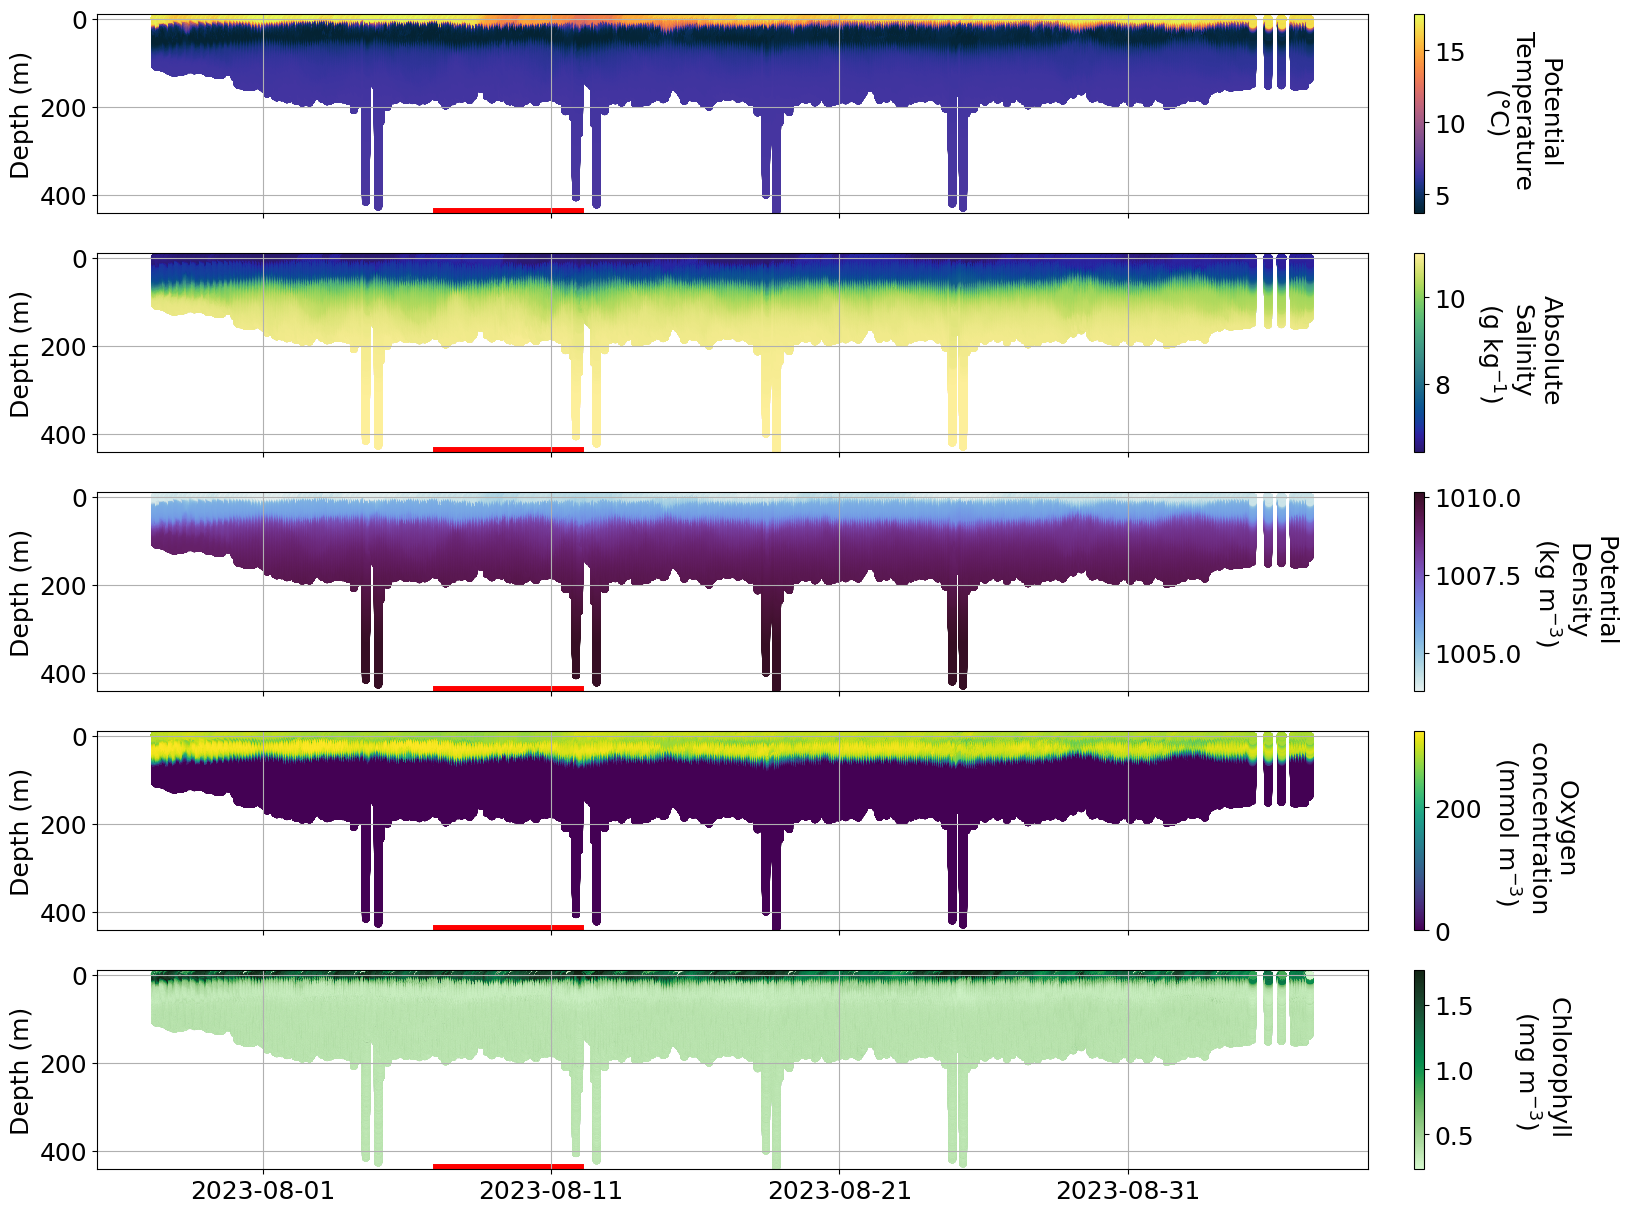

In [44]:
## Temperature and salinity for Western Gotland looks weird, let#s check if we see issues in the delayed mode data as well
plot_sel_data(basin='Western Gotland',date_start='2023-07-01', date_end='2023-09-01', delayed=True)

## 4. Spring blooms

In [45]:
plot_sel_data(basin='Bornholm',date_start='2023-01-01', date_end='2024-01-01',rectangle=False)

  0%|                                                                                                  | 0/19 [00:00<?, ?it/s]

/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
 11%|█████████▍                                                                                | 2/19 [00:00<00:03,  4.38it/s]

/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
 16%|██████████████▏                                                                           | 3/19 [00:00<00:04,  3.52it/s]

/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
 21%|██████████████████▉                                                                       | 4/19 [00:01<00:05,  2.98it/s]

/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
 26%|███████████████████████▋                                                                  | 5/19 [00:01<00:04,  2.91it/s]

/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
 32%|████████████████████████████▍                                                             | 6/19 [00:02<00:04,  2.76it/s]/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
 47%|██████████████████████████████████████████▋                                               | 9/19 [00:02<00:02,  4.15it/s]

/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
 53%|██████████████████████████████████████████████▊                                          | 10/19 [00:02<00:02,  3.70it/s]/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
 63%|████████████████████████████████████████████████████████▏                                | 12/19 [00:03<00:01,  4.15it/s]

/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
 68%|████████████████████████████████████████████████████████████▉                            | 13/19 [00:03<00:01,  3.55it/s]

/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
 74%|█████████████████████████████████████████████████████████████████▌                       | 14/19 [00:04<00:01,  3.18it/s]/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
 89%|███████████████████████████████████████████████████████████████████████████████▋         | 17/19 [00:04<00:00,  4.27it/s]

/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
 95%|████████████████████████████████████████████████████████████████████████████████████▎    | 18/19 [00:04<00:00,  3.68it/s]

/Users/eddifying/opt/miniconda3/envs/seaocn_env/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
100%|█████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.51it/s]


ValueError: 'backscatter_raw' is not present in all datasets.

#### Info
There are issues with some of the oxygen data and more info can be found here https://observations.voiceoftheocean.org/static/img/reports/Quality_Issue_1_AROD.pdf

In [ ]:
plot_sel_data(basin='Eastern Gotland',date_start='2023-01-01', date_end='2024-01-01',rectangle=False)

In [ ]:
plot_sel_data(basin='Skagerrak',date_start='2023-01-01', date_end='2024-01-01',rectangle=False)

## 5. Specific data with issues

In [ ]:
# SEA070 with pumped SeaBird CTD
name = ['delayed_SEA070_M15', 'delayed_SEA070_M15']
ds_delayed = utils.download_glider_dataset(name, nrt_only=False)

In [ ]:
full_data = []
for i in range(len(name)):
    full_data.append(ds_delayed[name[i]])
full_data = xr.concat(full_data, dim= 'time')

fig, ax = plt.subplots(5,1,figsize=(20, 15), sharex=True)
matplotlib.rcParams.update({'font.size': 18})
time=mdates.date2num(full_data.time)
t=ax[0].scatter( time,full_data.depth, c=full_data.temperature,s=20, cmap=cmo.thermal, vmin=np.nanpercentile(full_data.temperature, 0.5), vmax=np.nanpercentile(full_data.temperature, 99.5))
s=ax[1].scatter( time,full_data.depth, c=full_data.salinity,s=20,cmap=cmo.haline, vmin=np.nanpercentile(full_data.salinity, 0.5), vmax=np.nanpercentile(full_data.salinity, 99.5))
d=ax[2].scatter( time,full_data.depth, c=full_data.density, s=20, cmap=cmo.dense, vmin=np.nanpercentile(full_data.density, 0.5), vmax=np.nanpercentile(full_data.density, 99.5))
o=ax[3].scatter( time,full_data.depth, c=full_data.oxygen_frequency, s=20,vmin=np.nanpercentile(full_data.oxygen_frequency, 0.5), vmax=np.nanpercentile(full_data.oxygen_frequency, 99.5))
c=ax[4].scatter( time,full_data.depth, c=full_data.chlorophyll, s=20, cmap=cmo.algae, vmin=np.nanpercentile(full_data.chlorophyll, 0.5), vmax=np.nanpercentile(full_data.chlorophyll, 99.5))
    
[a.set_ylim(int(full_data.depth.max()+10),-10) for a in ax]
[a.grid() for a in ax]
ax[1].xaxis.reset_ticks()
ax[1].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday = 1, interval=3))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))


cbarT=plt.colorbar(t, ax=ax[0], pad = 0.03)
cbarT.set_label('Potential \nTemperature \n(°C)',labelpad=70, y=0.5, rotation=270,fontsize=18)
cbarS=plt.colorbar(s, ax=ax[1], pad = 0.03)
cbarS.set_label('Absolute \nSalinity \n(g kg$^{-1}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)
cbarD=plt.colorbar(d, ax=ax[2], pad = 0.03)
cbarD.set_label('Potential \nDensity \n(kg m$^{-3}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)
cbarO=plt.colorbar(o, ax=ax[3], pad = 0.03)
cbarO.set_label('Oxygen \nconcentration \n(mmol m$^{-3}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)
cbarC=plt.colorbar(c, ax=ax[4], pad = 0.03)
cbarC.set_label('Chlorophyll \n(mg m$^{-3}$)',labelpad=70, y=0.5, rotation=270,fontsize=18)

[a.tick_params(axis='both', which='major', labelsize=18) for a in ax]
[a.set_ylabel('Depth (m)',fontsize=18) for a in ax]

## This is all raw data and many adjustments have to be applied and various issues soruces should be considered
* Thermal hysteresis
* Quenching corrections
* Calibration (ex. optics dark count correction and scaling factor correction, oxygen calibration etc..)
* Electrical spikes
* Outliers
* Sensor failure
* Specific sensor issues (FLBBPC issues, FLBBCD issues, AROD and CODA issues)
* 
